In [1]:
import pandas as pd

df = pd.read_csv('input/df_quarterly_macro.csv')
df = df[df['Year'] <= 2019]
df = df.rename(columns={"Code" : "isocode"})

# Mapping from quarter number to month (Q1 = March, Q2 = June, etc.)
quarter_month_map = {1: 3, 2: 6, 3: 9, 4: 12}
df["month"] = df["Quarter"].map(quarter_month_map)
df["date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["month"].astype(str) + "-01")
df.drop(columns="month", inplace=True)  # optional cleanup
df = df.drop(columns=["Country", "Year", "Quarter"])

# Selecting relevant columns
static_cols = ['isocode', 'date', '1DLGDP']
#lag_cols = df.columns[df.columns.str.contains(r'_lag\d+$')]
lag_cols = df.columns[df.columns.str.endswith('_lag1') | df.columns.str.endswith('_lag2')]
cols_to_include = static_cols + lag_cols.to_list()
df = df[cols_to_include].copy()
df = df.reset_index(drop=True)
print("Number of units: ", df["isocode"].nunique())
df

Number of units:  49


,isocode,date,1DLGDP,1DLGDP_lag1,1DLGDP_lag2,1DLINDPRO_lag1,2DLINDPRO_lag1,1DLMANPRO_lag1,1DLRETAIL_lag1,MPR_lag1,...,RW_SPREAD_1D_lag2,RW_FFUNDS_1D_lag1,RW_FFUNDS_1D_lag2,RW_HPI_1DL_lag1,RW_HPI_1DL_lag2,RW_HPI_2DL_lag2,RW_TRADE_1DL_lag1,RW_TRADE_2DL_lag1,RW_WTI_1DL_lag1,RW_WTI_2DL_lag1
0,ARG,1997-03-01,2.078385,0.657755,0.657787,0.533193,-0.010754,0.587473,0.633271,6.026856,...,0.01833,-0.002829,-0.002995,0.865185,0.865399,-0.004953,0.768611,-0.036150,1.032762,-0.123308
1,ARG,1997-06-01,1.476696,2.078385,0.657787,0.533193,-0.010754,0.587473,0.633271,5.650000,...,0.01833,0.000000,-0.002995,-0.364861,0.865399,-0.004953,0.768611,-0.036150,-7.501409,-17.260051
2,ARG,1997-09-01,2.485988,1.476696,2.078385,0.533193,-0.010754,0.587473,0.633271,5.736667,...,0.01833,0.240000,0.000000,0.350853,-0.364861,-0.631360,0.768611,-0.036150,-13.722687,-6.221277
3,ARG,1997-12-01,1.342418,2.485988,1.476696,0.533193,-0.010754,0.587473,0.633271,7.126667,...,-0.10000,0.010000,0.240000,0.739762,0.350853,0.715714,0.768611,-0.036150,-0.604231,13.118455
4,ARG,1998-03-01,0.516006,1.342418,2.485988,0.533193,-0.010754,0.587473,0.633271,8.723333,...,-0.07000,-0.020000,0.010000,0.540879,0.739762,0.388909,0.768611,-0.036150,0.804833,1.409065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503,USA,2018-12-01,0.181616,0.719442,0.694924,0.838772,-0.309375,0.386628,0.633271,1.958333,...,0.01000,0.190000,0.290000,0.717932,0.876029,-0.262795,0.927117,0.339235,2.352025,-5.531121
4504,USA,2019-03-01,0.541243,0.181616,0.719442,0.129218,-0.709554,-0.434406,0.633271,2.208333,...,0.05000,0.290000,0.190000,0.390802,0.717932,-0.158097,-0.526443,-1.453560,-15.021240,-17.373265
4505,USA,2019-06-01,0.670759,0.541243,0.181616,-0.935471,-1.064690,-1.183483,0.633271,2.375000,...,0.59000,0.180000,0.290000,0.821697,0.390802,-0.327131,-0.641851,-0.115408,-8.978935,6.042305
4506,USA,2019-09-01,0.886030,0.670759,0.541243,-0.608246,0.327226,-0.805074,0.633271,2.375000,...,0.17000,0.000000,0.180000,0.844512,0.821697,0.430896,-0.048305,0.593545,8.828747,17.807681


In [2]:
# Configuration
unit_col = 'isocode'
time_col = 'date'
target_col = '1DLGDP'
target_unit = 'USA'
feature_cols = df.columns.difference([unit_col, time_col, target_col])
forecast_times = list(pd.date_range(start="2015-03-01", end="2019-12-01", freq="3MS"))
total_epochs = 1000

In [3]:
import torch
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

# Define cutoff dates for train/test split
train_cutoff = pd.to_datetime("2012-12-31")
test_start = pd.to_datetime("2013-01-01")
test_end = pd.to_datetime("2014-12-31")

# Separate target test data using the datetime column
target_test_df = df[(df[unit_col] == target_unit) & (df['date'].between(test_start, test_end))]
X_target_test = target_test_df[feature_cols]
y_target_test = target_test_df[target_col]

# Train one model per country (idiosyncratic data) and test on BRA
country_rmse = {}

for iso in df[unit_col].unique():
    train_df = df[(df[unit_col] == iso) & (df[time_col] <= train_cutoff)]
    if len(train_df) < 5:
        continue  # skip if not enough data
    
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]

    model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_target_test)
    rmse = sqrt(mean_squared_error(y_target_test, y_pred))
    country_rmse[iso] = rmse

# Convert to DataFrame and sort
similarity_rmse_df = pd.DataFrame.from_dict(country_rmse, orient='index', columns=['RMSE'])
similarity_rmse_df = similarity_rmse_df.sort_values(by='RMSE')

# Get donor list (exclude target)
donor_isos = similarity_rmse_df.index.drop(target_unit).tolist()
similarity_scores = 1 / (1 + similarity_rmse_df.loc[donor_isos, 'RMSE'].values)
sim_tensor = torch.tensor(similarity_scores, dtype=torch.float32)
for iso, score in zip(donor_isos[:10], similarity_scores[:10]):
    print(f"Similarity score for {iso}: {score:.4f}")  

Similarity score for AUT: 0.6715
Similarity score for GBR: 0.6685
Similarity score for CHE: 0.6678
Similarity score for PRT: 0.6622
Similarity score for NOR: 0.6619
Similarity score for ROU: 0.6551
Similarity score for BEL: 0.6534
Similarity score for MEX: 0.6511
Similarity score for SWE: 0.6476
Similarity score for DNK: 0.6419


In [4]:
from OptimalPanel.optimizer import OptimalBundleRL

rl = OptimalBundleRL(df=df, unit_col=unit_col, time_col=time_col, target_col=target_col, feature_cols=feature_cols, 
                     target_unit=target_unit, donor_units=donor_isos, similarities=sim_tensor, forecast_times=forecast_times)

rl.train(n_epochs=total_epochs, save=False, save_path=f"results/results_{target_unit}.pkl")

Epoch 0 — Avg MSE: 0.0573, Bundle Size: 35
Epoch 10 — Avg MSE: 0.0438, Bundle Size: 22
Epoch 20 — Avg MSE: 0.0851, Bundle Size: 29
Epoch 30 — Avg MSE: 0.0716, Bundle Size: 21
Epoch 40 — Avg MSE: 0.0653, Bundle Size: 24
Epoch 50 — Avg MSE: 0.0636, Bundle Size: 24
Epoch 60 — Avg MSE: 0.1311, Bundle Size: 24
Epoch 70 — Avg MSE: 0.1260, Bundle Size: 24
Epoch 80 — Avg MSE: 0.0574, Bundle Size: 27
Epoch 90 — Avg MSE: 0.0503, Bundle Size: 26
Epoch 100 — Avg MSE: 0.0537, Bundle Size: 24
Epoch 110 — Avg MSE: 0.0571, Bundle Size: 19
Epoch 120 — Avg MSE: 0.0758, Bundle Size: 14
Epoch 130 — Avg MSE: 0.0656, Bundle Size: 23
Epoch 140 — Avg MSE: 0.0516, Bundle Size: 23
Epoch 150 — Avg MSE: 0.1056, Bundle Size: 25
Epoch 160 — Avg MSE: 0.0826, Bundle Size: 29
Epoch 170 — Avg MSE: 0.0476, Bundle Size: 20
Epoch 180 — Avg MSE: 0.1029, Bundle Size: 20
Epoch 190 — Avg MSE: 0.0895, Bundle Size: 25
Epoch 200 — Avg MSE: 0.0591, Bundle Size: 24
Epoch 210 — Avg MSE: 0.0717, Bundle Size: 22
Epoch 220 — Avg MSE: 

In [5]:
rl.print_top_bundles()


🔹 Top 5 Bundles by RMSE:
1. Epoch 456 — RMSE: 0.0418, Bundle: ['AUT', 'CHE', 'NOR', 'ROU', 'BEL', 'NZL', 'JPN', 'SVN', 'FIN', 'DEU', 'BRA', 'HRV', 'ESP', 'NLD', 'CZE', 'IDN', 'SVK', 'ITA', 'CHL', 'RUS', 'KOR', 'IND']
2. Epoch 517 — RMSE: 0.0426, Bundle: ['CHE', 'BEL', 'SWE', 'DNK', 'HUN', 'JPN', 'SVN', 'FRA', 'ZAF', 'HRV', 'ESP', 'NLD', 'CZE', 'IDN', 'KOR', 'IND', 'ARG', 'BGR']
3. Epoch 687 — RMSE: 0.0437, Bundle: ['AUT', 'BEL', 'DNK', 'LUX', 'SVN', 'CAN', 'ZAF', 'BRA', 'CZE', 'CRI', 'ITA', 'RUS', 'LTU', 'KOR', 'PER', 'POL', 'TUR', 'ARG', 'BGR']
4. Epoch 529 — RMSE: 0.0438, Bundle: ['PRT', 'BEL', 'MEX', 'SWE', 'DNK', 'HUN', 'SVN', 'CAN', 'FRA', 'SAU', 'ZAF', 'BRA', 'ESP', 'NLD', 'IDN', 'SVK', 'RUS', 'KOR', 'PER', 'POL', 'ARG', 'BGR']
5. Epoch  10 — RMSE: 0.0438, Bundle: ['AUT', 'CHE', 'PRT', 'ROU', 'BEL', 'DNK', 'JPN', 'CAN', 'FRA', 'DEU', 'SAU', 'ESP', 'NLD', 'COL', 'CZE', 'CRI', 'ISR', 'SVK', 'EST', 'GRC', 'PER', 'ARG']


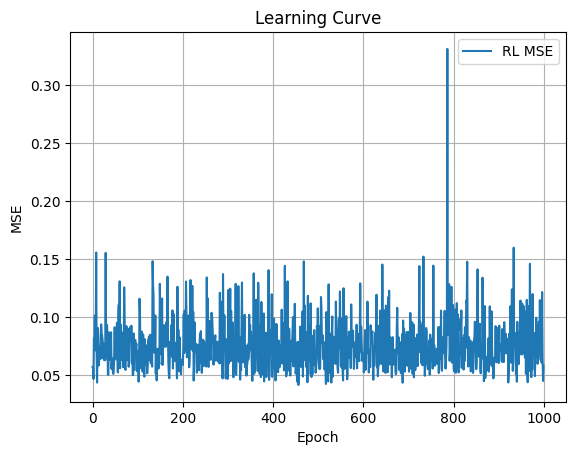

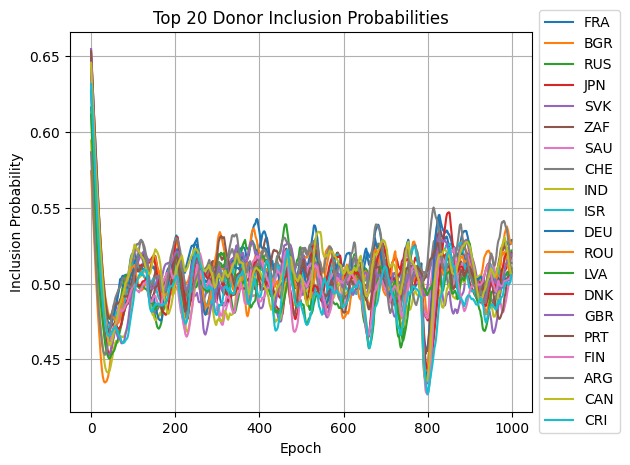

In [6]:
rl.plot_learning_curve()
rl.plot_donor_probs(top_n=20)